In [74]:
!pip install keras-cv

In [75]:
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow import keras as keras


# Set seeds for random number generators in NumPy, Python and Tensor Flow
seed=42
np.random.seed(42)
tf.random.set_seed(42);
tf.compat.v1.set_random_seed(42);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.gridspec as gridspec
import cv2
import keras_cv
from sklearn.utils.class_weight import compute_class_weight
#import nrrd # to open our images
#from cleanvision import Imagelab

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [76]:
#full_slice_clean= np.load('/content/drive/MyDrive/AI/Final_assignment/full_slice_dataset_clean.npy')
#tumor_class_clean = np.load('/content/drive/MyDrive/AI/Final_assignment/tumor_class_clean.npy')
#nodule_dataset = np.load('/content/drive/MyDrive/AI/Final_assignment/nodule_dataset.npy')
full_slice_clean=np.load('/kaggle/input/tumor-classification/full_slice_dataset_clean.npy')
tumor_class_clean=np.load('/kaggle/input/tumor-classification/tumor_class_clean.npy')
nodule_dataset=np.load('/kaggle/input/tumor-classification/nodule_dataset_clean.npy')
#df = pd.read_excel('/content/drive/MyDrive/AI/Final_assignment/dataset_lung.xlsx')
##df=pd.read_excel('/kaggle/input/dataset-lung/dataset_lung.xlsx')
##tumor_class = df['TumorClass'].values

print(f"number of full_slice images: {len(full_slice_clean)}")
print(f"number of full_slice labels: {len(tumor_class_clean)}")

print(f'number of nodule images: {len(nodule_dataset)}')

number of full_slice images: 2276
number of full_slice labels: 2276
number of nodule images: 2276


In [77]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Store nodule coordinates
nodule_coordinates = []

for i in range(len(full_slice_clean)):
    full_image = full_slice_clean[i].astype(np.float32)  # Convert to float32
    nodule_image = nodule_dataset[i].astype(np.float32)  # Convert to float32

    # Ensure nodule image is smaller than the full slice
    if nodule_image.shape[0] > full_image.shape[0] or nodule_image.shape[1] > full_image.shape[1]:
        print(f"Skipping index {i} - Nodule is larger than full slice")
        nodule_coordinates.append(None)
        continue

    # Apply template matching
    result = cv2.matchTemplate(full_image, nodule_image, cv2.TM_CCOEFF_NORMED)

    # Get the best match location
    _, _, _, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc  # (x, y) of top-left corner in full slice

    # Compute the center of the nodule
    h, w = nodule_image.shape
    center_x = top_left[0] + w // 2
    center_y = top_left[1] + h // 2

    # Store the coordinates
    nodule_coordinates.append((center_x, center_y))

# Convert to NumPy array 
nodule_coordinates = np.array(nodule_coordinates, dtype=object)

print("Nodule coordinates computed and saved successfully!")


Nodule coordinates computed and saved successfully!


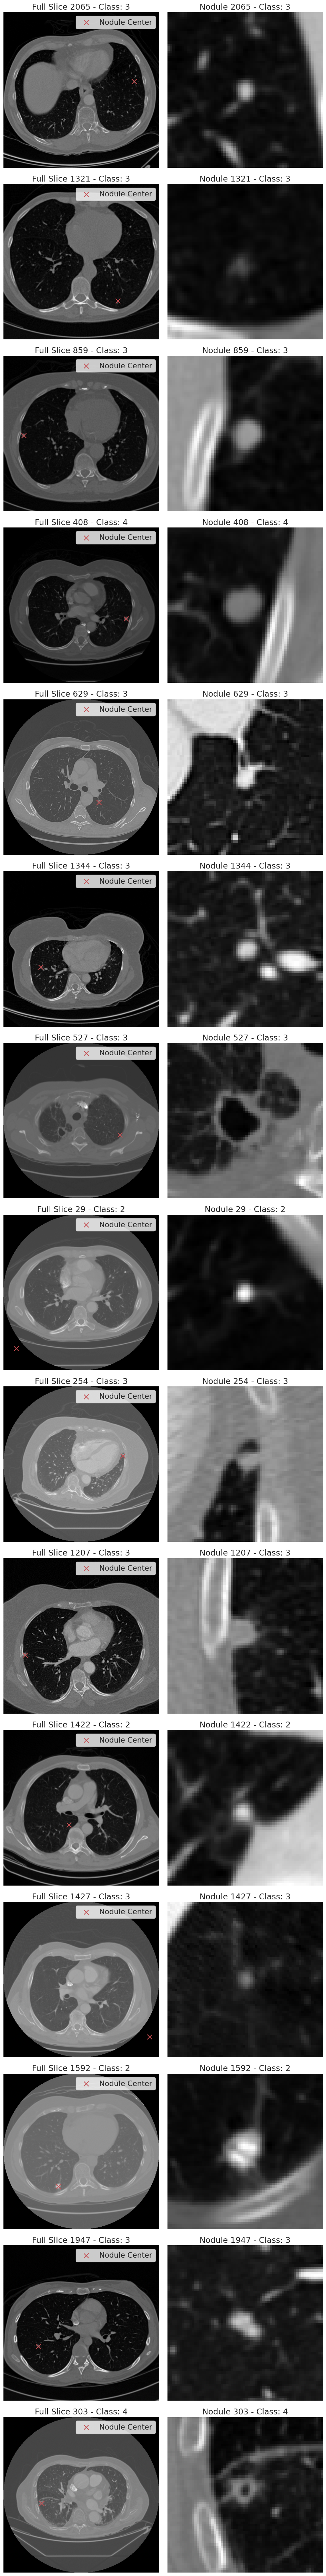

In [78]:
import numpy as np
import matplotlib.pyplot as plt



# Select random examples where nodules exist
num_samples = 15  # Change this number as needed
indices_with_nodules = [i for i, center in enumerate(nodule_coordinates) if center is not None]
selected_indices = np.random.choice(indices_with_nodules, min(num_samples, len(indices_with_nodules)), replace=False)

# Plot images
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Rows: num_samples, Columns: 2 (full slice + nodule)

for row_idx, img_idx in enumerate(selected_indices):
    full_image = full_slice_clean[img_idx]  # Full CT slice
    nodule_image = nodule_dataset[img_idx]  # Nodule image
    center_x, center_y = nodule_coordinates[img_idx]  # Detected nodule center
    tumor_class = tumor_class_clean[img_idx]  # Tumor class label

    # Plot full slice with center
    axes[row_idx, 0].imshow(full_image, cmap="gray")
    axes[row_idx, 0].scatter(center_x, center_y, c='r', marker='x', s=100, label="Nodule Center")
    axes[row_idx, 0].set_title(f"Full Slice {img_idx} - Class: {tumor_class}")
    axes[row_idx, 0].axis("off")
    axes[row_idx, 0].legend()

    # Plot the corresponding nodule image
    axes[row_idx, 1].imshow(nodule_image, cmap="gray")
    axes[row_idx, 1].set_title(f"Nodule {img_idx} - Class: {tumor_class}")
    axes[row_idx, 1].axis("off")

plt.tight_layout()
plt.show()


## 🔧 Prepare dataset

In [79]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load computed coordinates
nodule_coordinates = nodule_coordinates/512
# Split all datasets while maintaining alignment
X_train_full, X_val_full, y_train_full, y_val_full, X_train_nodule, X_val_nodule, train_coords, val_coords = train_test_split(
    full_slice_clean, tumor_class_clean, nodule_dataset, nodule_coordinates, 
    test_size=0.2, random_state=42, stratify=tumor_class_clean
)

# Print dataset shapes to verify alignment
print("Training Full Slice Shape:", X_train_full.shape)
print("Training Nodule Shape:", X_train_nodule.shape)
print("Training Label Shape:", y_train_full.shape)
print("Training Coordinates Shape:", len(train_coords))

print("Validation Full Slice Shape:", X_val_full.shape)
print("Validation Nodule Shape:", X_val_nodule.shape)
print("Validation Label Shape:", y_val_full.shape)
print("Validation Coordinates Shape:", len(val_coords))

#binary classification
y_train_full_bin = np.where(y_train_full < 4, 0, 1)
y_val_full_bin = np.where(y_val_full <4, 0, 1)


Training Full Slice Shape: (1820, 512, 512)
Training Nodule Shape: (1820, 64, 64)
Training Label Shape: (1820,)
Training Coordinates Shape: 1820
Validation Full Slice Shape: (456, 512, 512)
Validation Nodule Shape: (456, 64, 64)
Validation Label Shape: (456,)
Validation Coordinates Shape: 456


In [80]:
train_coords

array([[0.693359375, 0.806640625],
       [0.201171875, 0.7421875],
       [0.59765625, 0.75390625],
       ...,
       [0.263671875, 0.548828125],
       [0.802734375, 0.53515625],
       [0.228515625, 0.53125]], dtype=object)

In [81]:
import numpy as np

# Convert the datasets to numpy arrays (tensors)
X_train_full = np.asarray(X_train_full)
y_train_full = np.asarray(y_train_full)
X_val_full = np.asarray(X_val_full)
y_val_full = np.asarray(y_val_full)
y_train_full_bin = np.asarray(y_train_full_bin)
y_val_full_bin = np.asarray(y_val_full_bin)
# Assuming y_train_nodule and y_val_nodule should be the same as y_train_full and y_val_full,
# because the tumor class is the same for full slices and nodules (aligned).
y_train_nodule = y_train_full
y_val_nodule = y_val_full

# Convert the nodule dataset to numpy arrays (tensors)
X_train_nodule = np.asarray(X_train_nodule)
X_val_nodule = np.asarray(X_val_nodule)

# Convert nodule coordinates to numpy arrays (tensors)
train_coords = np.asarray(train_coords, dtype=object)  # Use dtype=object for variable-length lists
val_coords = np.asarray(val_coords, dtype=object)

# Print out the shapes to confirm conversion
print("Training Full Slice Shape:", X_train_full.shape)
print("Training Nodule Shape:", X_train_nodule.shape)
print("Training Labels Shape:", y_train_full.shape)
print("Training Coordinates Shape:", train_coords.shape)

print("Validation Full Slice Shape:", X_val_full.shape)
print("Validation Nodule Shape:", X_val_nodule.shape)
print("Validation Labels Shape:", y_val_full.shape)
print("Validation Coordinates Shape:", val_coords.shape)



Training Full Slice Shape: (1820, 512, 512)
Training Nodule Shape: (1820, 64, 64)
Training Labels Shape: (1820,)
Training Coordinates Shape: (1820, 2)
Validation Full Slice Shape: (456, 512, 512)
Validation Nodule Shape: (456, 64, 64)
Validation Labels Shape: (456,)
Validation Coordinates Shape: (456, 2)


In [82]:
print(X_train_full.shape)
print(y_train_full.shape)

(1820, 512, 512)
(1820,)


## 🔄 Process Data:

In [83]:
# add the extra dimension for the color
X_train_full = np.expand_dims(X_train_full, axis=-1)  # add an extra channel in X_train
X_val_full = np.expand_dims(X_val_full, axis=-1)  # same for X_val
X_train_nodule = np.expand_dims(X_train_nodule, axis=-1)
X_val_nodule = np.expand_dims(X_val_nodule, axis=-1)

# add an extra dimension
#y_train_full = np.expand_dims(y_train_full, axis=-1)  # add an extra channel in X_train
#y_val_full = np.expand_dims(y_val_full, axis=-1)  # same for X_val
#y_train_nodule = np.expand_dims(y_train_nodule, axis=-1)
#y_val_nodule = np.expand_dims(y_val_nodule, axis=-1)

print("full_slices:")
print(f"X_train: {X_train_full.shape}")
print(f"y_train: {y_train_full.shape}")
print(f"X_val: {X_val_full.shape}")
print(f"y_val: {y_val_full.shape}")
print("\n")

print("nodules:")
print(f"X_train: {X_train_nodule.shape}")
print(f"y_train: {y_train_nodule.shape}")
print(f"X_val: {X_val_nodule.shape}")
print(f"y_val: {y_val_nodule.shape}")

full_slices:
X_train: (1820, 512, 512, 1)
y_train: (1820,)
X_val: (456, 512, 512, 1)
y_val: (456,)


nodules:
X_train: (1820, 64, 64, 1)
y_train: (1820,)
X_val: (456, 64, 64, 1)
y_val: (456,)


In [84]:
# check the type
print(X_train_nodule.dtype)
print(y_train_nodule.dtype)
print(X_train_full.dtype)
print(y_train_full.dtype)
# i will transform everything into float32 because this format is better to be fed into the network

int16
int64
int16
int64


In [85]:
# trasform in tf.float32
X_train_full = X_train_full.astype(np.float32)
y_train_full = y_train_full.astype(np.float32)
X_val_full = X_val_full.astype(np.float32)
y_val_full = y_val_full.astype(np.float32)
train_coords = train_coords.astype(np.float32)

X_train_nodule = X_train_nodule.astype(np.float32)
y_train_nodule = y_train_nodule.astype(np.float32)
X_val_nodule = X_val_nodule.astype(np.float32)
y_val_nodule= y_val_nodule.astype(np.float32)
val_coords = val_coords.astype(np.float32)


Normalization

Valore dei pixel da -32768.0 a -31458.380859375: 8 occorrenze
Valore dei pixel da -31458.380859375 a -30148.759765625: 0 occorrenze
Valore dei pixel da -30148.759765625 a -28839.140625: 0 occorrenze
Valore dei pixel da -28839.140625 a -27529.51953125: 0 occorrenze
Valore dei pixel da -27529.51953125 a -26219.900390625: 0 occorrenze
Valore dei pixel da -26219.900390625 a -24910.279296875: 0 occorrenze
Valore dei pixel da -24910.279296875 a -23600.66015625: 0 occorrenze
Valore dei pixel da -23600.66015625 a -22291.0390625: 0 occorrenze
Valore dei pixel da -22291.0390625 a -20981.419921875: 1 occorrenze
Valore dei pixel da -20981.419921875 a -19671.80078125: 1 occorrenze
Valore dei pixel da -19671.80078125 a -18362.1796875: 0 occorrenze
Valore dei pixel da -18362.1796875 a -17052.560546875: 0 occorrenze
Valore dei pixel da -17052.560546875 a -15742.9404296875: 0 occorrenze
Valore dei pixel da -15742.9404296875 a -14433.3203125: 0 occorrenze
Valore dei pixel da -14433.3203125 a -13123.7001

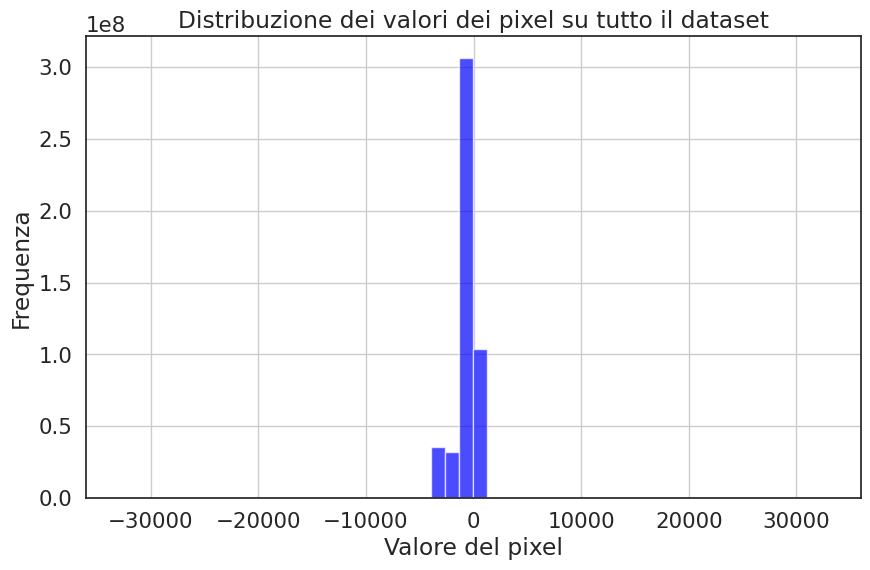

In [86]:
#FULL SLICE
# Prendi tutte le immagini dal dataset (ad esempio X_train_full)
all_pixels = X_train_full.flatten()  # Appiattisce tutte le immagini in un array 1D

# Calcola la distribuzione dei valori dei pixel usando np.histogram
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# Stampa i risultati
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")

# Crea l'istogramma dei valori dei pixel su tutte le immagini
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()


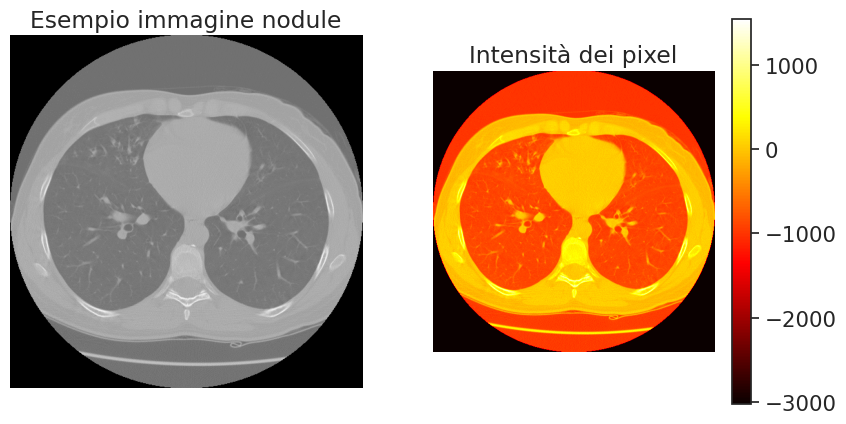

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_intensity(image, title="Image"):
    plt.figure(figsize=(10, 5))
    
    # Mostra l'immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    # Mostra l'immagine con la heatmap delle intensità
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='hot')  # Usa la mappa dei colori 'hot' per la heatmap
    plt.title('Intensità dei pixel')
    plt.colorbar()  # Aggiungi una barra di intensità
    plt.axis('off')
    
    plt.show()

# Visualizza un esempio di immagine con la heatmap
show_image_with_intensity(X_train_full[8], title="Esempio immagine nodule")


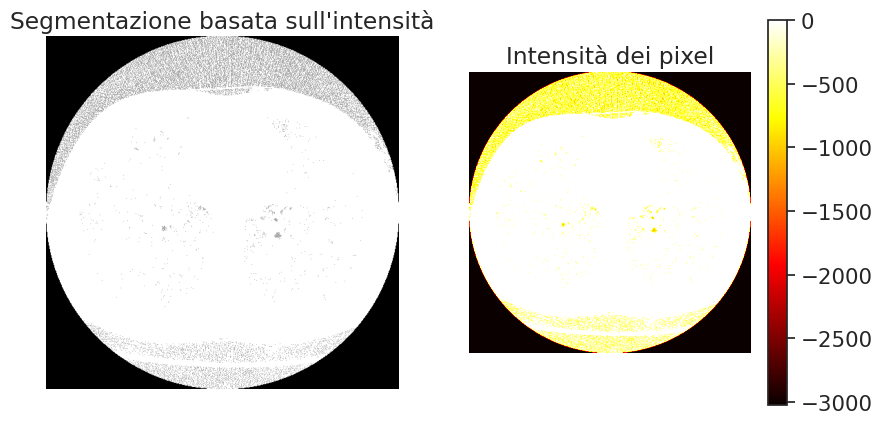

In [88]:
def segment_by_intensity(image, low_threshold, high_threshold):
# Crea una maschera dove i valori dei pixel sono compresi tra le soglie
    mask = (image > low_threshold) & (image < high_threshold)
    
    # Applica la maschera all'immagine originale per estrarre solo quelle aree
    segmented_image = np.zeros_like(image)
    segmented_image[mask] = image[mask]
    
    return segmented_image

# Segmenta l'immagine tra -500 e 500, ad esempio
segmented_full = segment_by_intensity(X_train_full[8], -30000, -1000)

# Visualizza l'immagine segmentata
show_image_with_intensity(segmented_full, title="Segmentazione basata sull'intensità")


Valore dei pixel da -1000.0 a -972.0: 152287062 occorrenze
Valore dei pixel da -972.0 a -944.0: 21341861 occorrenze
Valore dei pixel da -944.0 a -916.0: 21654589 occorrenze
Valore dei pixel da -916.0 a -888.0: 22879027 occorrenze
Valore dei pixel da -888.0 a -860.0: 18122559 occorrenze
Valore dei pixel da -860.0 a -832.0: 13935905 occorrenze
Valore dei pixel da -832.0 a -804.0: 10119182 occorrenze
Valore dei pixel da -804.0 a -776.0: 7024222 occorrenze
Valore dei pixel da -776.0 a -748.0: 4879022 occorrenze
Valore dei pixel da -748.0 a -720.0: 3505035 occorrenze
Valore dei pixel da -720.0 a -692.0: 2639151 occorrenze
Valore dei pixel da -692.0 a -664.0: 2087865 occorrenze
Valore dei pixel da -664.0 a -636.0: 1721199 occorrenze
Valore dei pixel da -636.0 a -608.0: 1463742 occorrenze
Valore dei pixel da -608.0 a -580.0: 1280579 occorrenze
Valore dei pixel da -580.0 a -552.0: 1146544 occorrenze
Valore dei pixel da -552.0 a -524.0: 1049794 occorrenze
Valore dei pixel da -524.0 a -496.0: 98

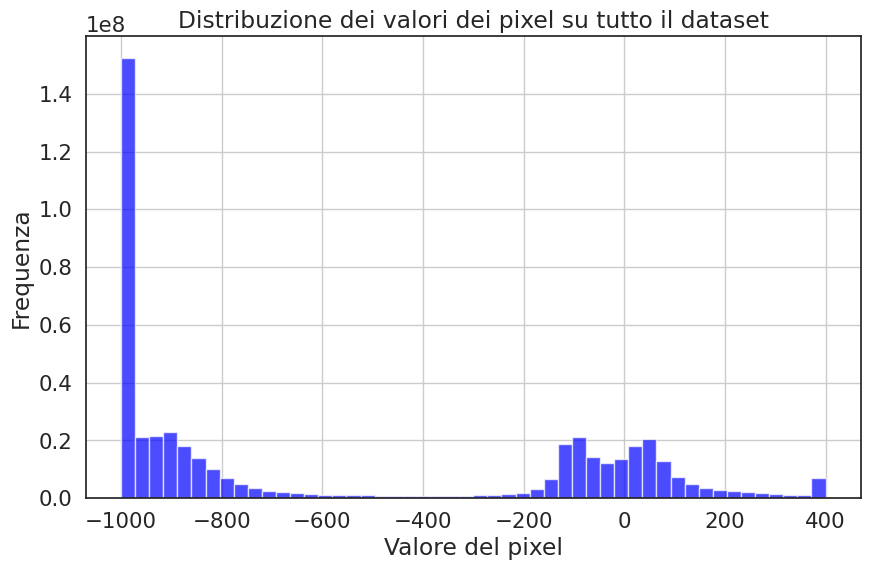

In [89]:
# Definisci i limiti per il clipping
lower_bound = -1000
upper_bound = 400

# Applica il clipping ai dataset
X_train_full = np.clip(X_train_full, lower_bound, upper_bound)
X_val_full = np.clip(X_val_full, lower_bound, upper_bound)

# Vizualization
all_pixels = X_train_full.flatten()  # Appiattisce tutte le immagini in un array 1D

# Calcola la distribuzione dei valori dei pixel usando np.histogram
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# Stampa i risultati
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")


# Crea l'istogramma dei valori dei pixel su tutte le immagini
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()


Valore dei pixel da -2048.0 a -1945.6199951171875: 61 occorrenze
Valore dei pixel da -1945.6199951171875 a -1843.239990234375: 3 occorrenze
Valore dei pixel da -1843.239990234375 a -1740.8599853515625: 1 occorrenze
Valore dei pixel da -1740.8599853515625 a -1638.47998046875: 2 occorrenze
Valore dei pixel da -1638.47998046875 a -1536.0999755859375: 1 occorrenze
Valore dei pixel da -1536.0999755859375 a -1433.719970703125: 0 occorrenze
Valore dei pixel da -1433.719970703125 a -1331.3399658203125: 0 occorrenze
Valore dei pixel da -1331.3399658203125 a -1228.9599609375: 0 occorrenze
Valore dei pixel da -1228.9599609375 a -1126.5799560546875: 29 occorrenze
Valore dei pixel da -1126.5799560546875 a -1024.199951171875: 463 occorrenze
Valore dei pixel da -1024.199951171875 a -921.8200073242188: 704061 occorrenze
Valore dei pixel da -921.8200073242188 a -819.4400024414062: 2813577 occorrenze
Valore dei pixel da -819.4400024414062 a -717.0599975585938: 1218782 occorrenze
Valore dei pixel da -717

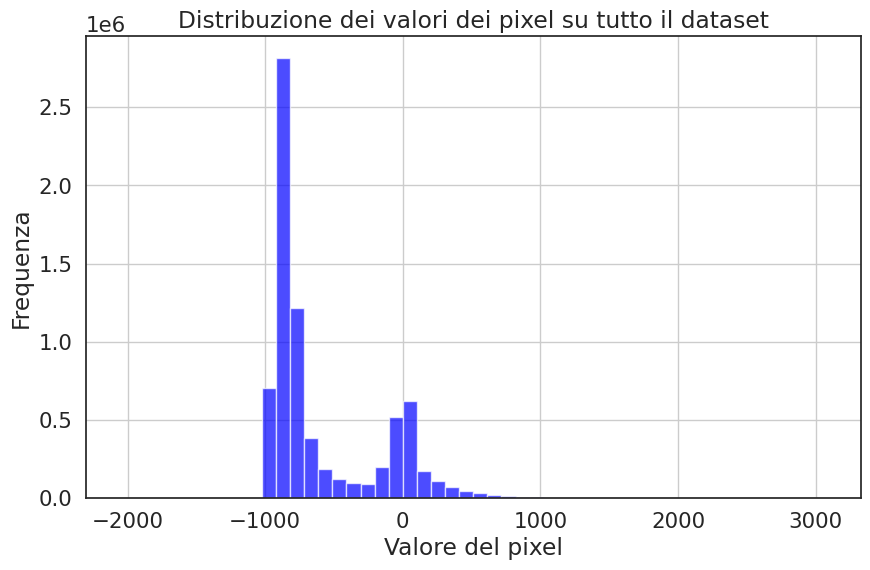

In [90]:
# NODULE
# Prendi tutte le immagini dal dataset (ad esempio X_train_full)
all_pixels = X_train_nodule.flatten()  # Appiattisce tutte le immagini in un array 1D

# Calcola la distribuzione dei valori dei pixel usando np.histogram
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# Stampa i risultati
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")

# Crea l'istogramma dei valori dei pixel su tutte le immagini
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()


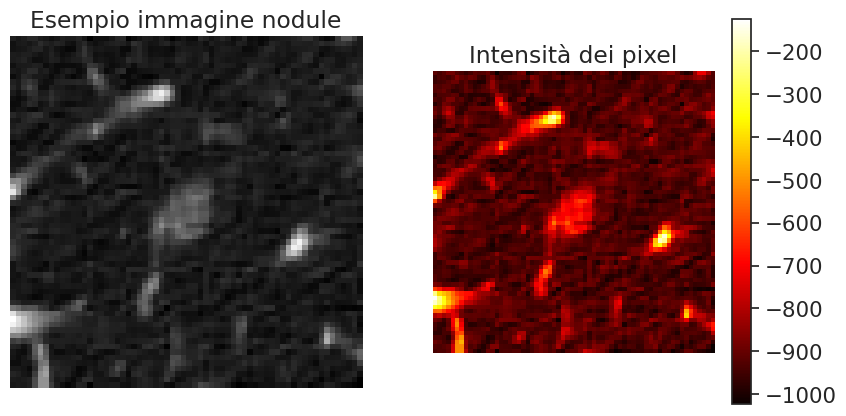

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_intensity(image, title="Image"):
    plt.figure(figsize=(10, 5))
    
    # Mostra l'immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    # Mostra l'immagine con la heatmap delle intensità
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='hot')  # Usa la mappa dei colori 'hot' per la heatmap
    plt.title('Intensità dei pixel')
    plt.colorbar()  # Aggiungi una barra di intensità
    plt.axis('off')
    
    plt.show()

# Visualizza un esempio di immagine con la heatmap
show_image_with_intensity(X_train_nodule[100], title="Esempio immagine nodule")


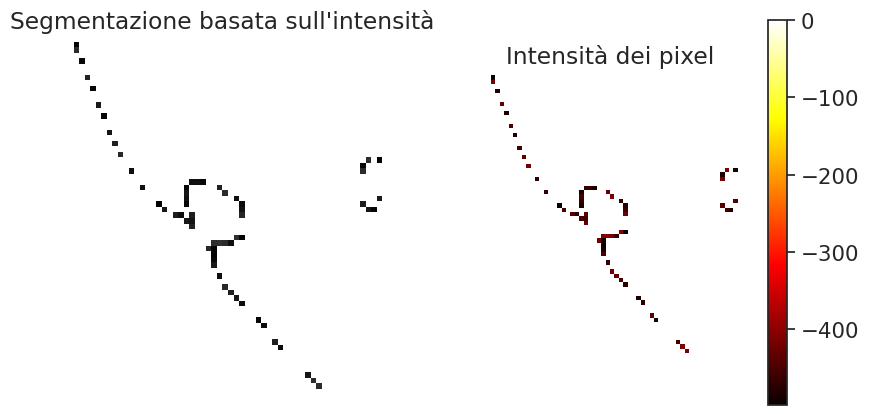

In [92]:
def segment_by_intensity(image, low_threshold, high_threshold):
# Crea una maschera dove i valori dei pixel sono compresi tra le soglie
    mask = (image > low_threshold) & (image < high_threshold)
    
    # Applica la maschera all'immagine originale per estrarre solo quelle aree
    segmented_image = np.zeros_like(image)
    segmented_image[mask] = image[mask]
    
    return segmented_image

# Segmenta l'immagine tra -500 e 500, ad esempio
segmented_nodule = segment_by_intensity(X_train_nodule[14], -500, -400)

# Visualizza l'immagine segmentata
show_image_with_intensity(segmented_nodule, title="Segmentazione basata sull'intensità")


Valore dei pixel da -1000.0 a -972.0: 111846 occorrenze
Valore dei pixel da -972.0 a -944.0: 213075 occorrenze
Valore dei pixel da -944.0 a -916.0: 491490 occorrenze
Valore dei pixel da -916.0 a -888.0: 779755 occorrenze
Valore dei pixel da -888.0 a -860.0: 862486 occorrenze
Valore dei pixel da -860.0 a -832.0: 765015 occorrenze
Valore dei pixel da -832.0 a -804.0: 585129 occorrenze
Valore dei pixel da -804.0 a -776.0: 416594 occorrenze
Valore dei pixel da -776.0 a -748.0: 290185 occorrenze
Valore dei pixel da -748.0 a -720.0: 203353 occorrenze
Valore dei pixel da -720.0 a -692.0: 148425 occorrenze
Valore dei pixel da -692.0 a -664.0: 112448 occorrenze
Valore dei pixel da -664.0 a -636.0: 88106 occorrenze
Valore dei pixel da -636.0 a -608.0: 71237 occorrenze
Valore dei pixel da -608.0 a -580.0: 59398 occorrenze
Valore dei pixel da -580.0 a -552.0: 50937 occorrenze
Valore dei pixel da -552.0 a -524.0: 44566 occorrenze
Valore dei pixel da -524.0 a -496.0: 39165 occorrenze
Valore dei pixe

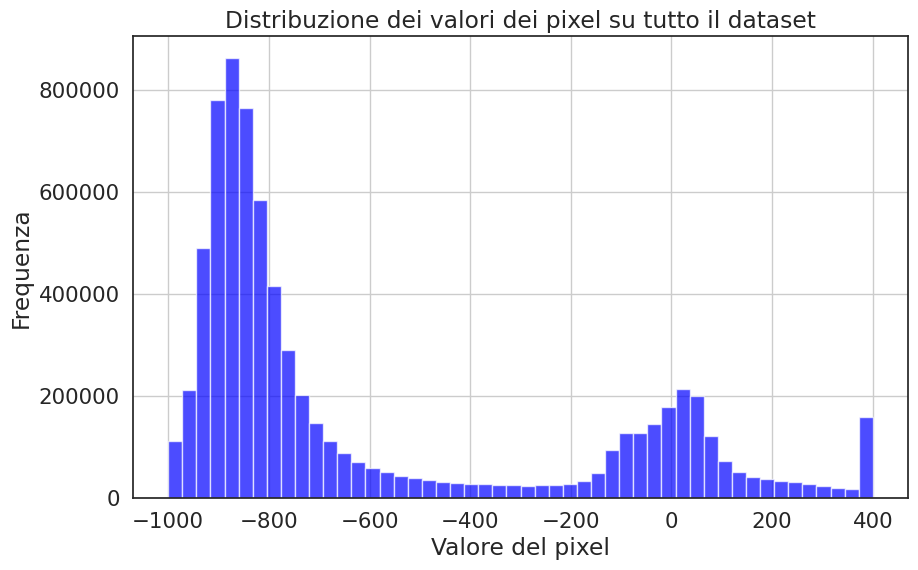

In [93]:

# Definisci i limiti per il clipping
lower_bound = -1000
upper_bound = 400

# Applica il clipping ai dataset
X_train_nodule = np.clip(X_train_nodule, lower_bound, upper_bound)
X_val_nodule = np.clip(X_val_nodule, lower_bound, upper_bound)

# Prendi tutte le immagini dal dataset (ad esempio X_train_nodule)
all_pixels = X_train_nodule.flatten()  # Appiattisce tutte le immagini in un array 1D

# Calcola la distribuzione dei valori dei pixel usando np.histogram
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# Stampa i risultati
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")
# Vizualization
all_pixels = X_train_nodule.flatten()  # Appiattisce tutte le immagini in un array 1D

# Crea l'istogramma dei valori dei pixel su tutte le immagini
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()


Preprocessing completato con CLAHE su X_train_nodule!


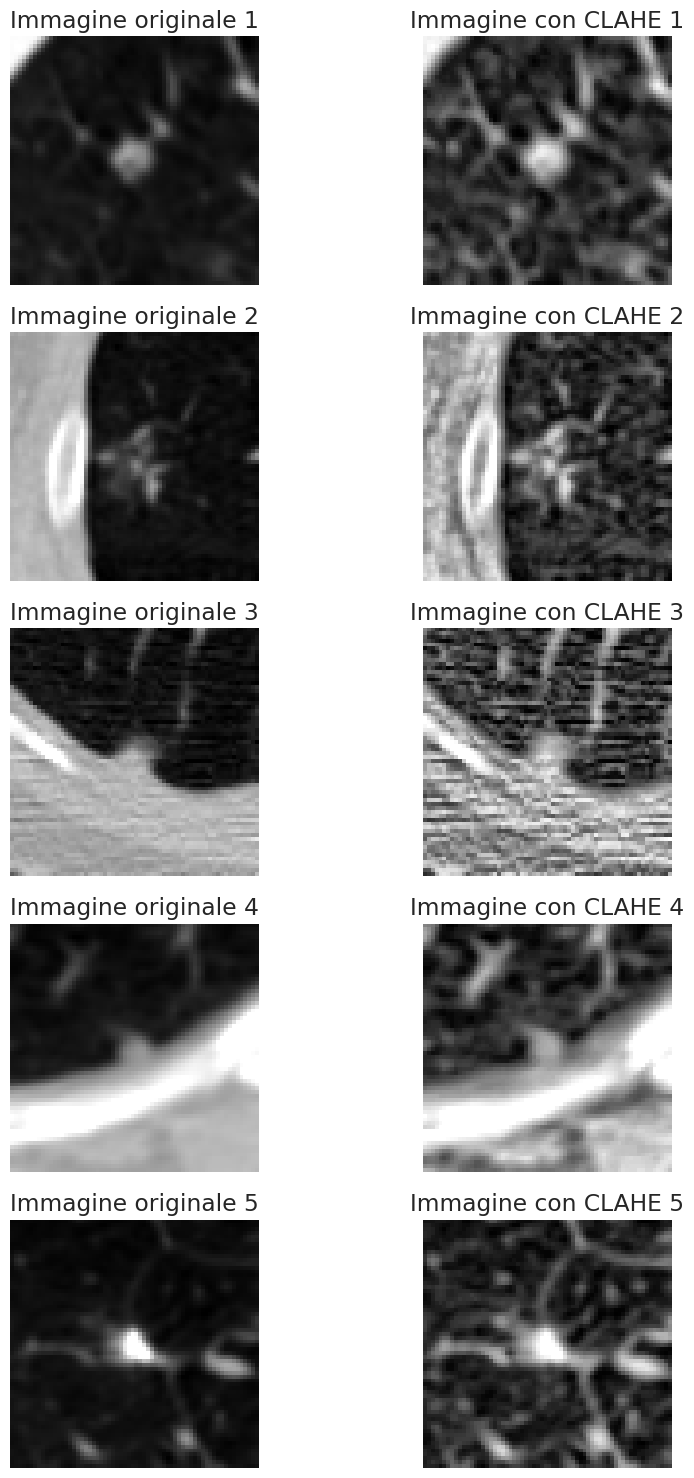

In [94]:

import cv2
import numpy as np

# Funzione per applicare CLAHE a un'immagine
def apply_clahe(image):
    # Converti l'immagine in formato 8-bit se non lo è già
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Applica CLAHE (impostazioni standard che puoi modificare se necessario)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Applica CLAHE a tutte le immagini nei vari dataset 
X_train_nodule_clahe = np.array([apply_clahe(img) for img in X_train_nodule])
X_val_nodule_clahe = np.array([apply_clahe(img) for img in X_val_nodule])
X_train_full_clahe = np.array([apply_clahe(img) for img in X_train_full])
X_val_full_clahe = np.array([apply_clahe(img) for img in X_val_full])



print("Preprocessing completato con CLAHE su X_train_nodule!")

# Seleziona 5 immagini casuali dal dataset
n_images = 5
random_indices = np.random.choice(len(X_train_nodule), n_images, replace=False)
sample_images = [X_train_nodule[i] for i in random_indices]
sample_images_clahe = [X_train_nodule_clahe[i] for i in random_indices]


# Visualizza le immagini prima e dopo CLAHE
fig, axes = plt.subplots(n_images, 2, figsize=(10, 15))

for i in range(n_images):
    # Immagine originale
    axes[i, 0].imshow(sample_images[i], cmap='gray')
    axes[i, 0].set_title(f"Immagine originale {i+1}")
    axes[i, 0].axis('off')
    
    # Immagine con CLAHE
    axes[i, 1].imshow(sample_images_clahe[i], cmap='gray')
    axes[i, 1].set_title(f"Immagine con CLAHE {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

X_train_nodule=X_train_nodule_clahe
X_val_nodule=X_val_nodule_clahe
X_train_full=X_train_full_clahe
X_val_full=X_val_full_clahe


Preprocessing completato con denoising su X_train_nodule!


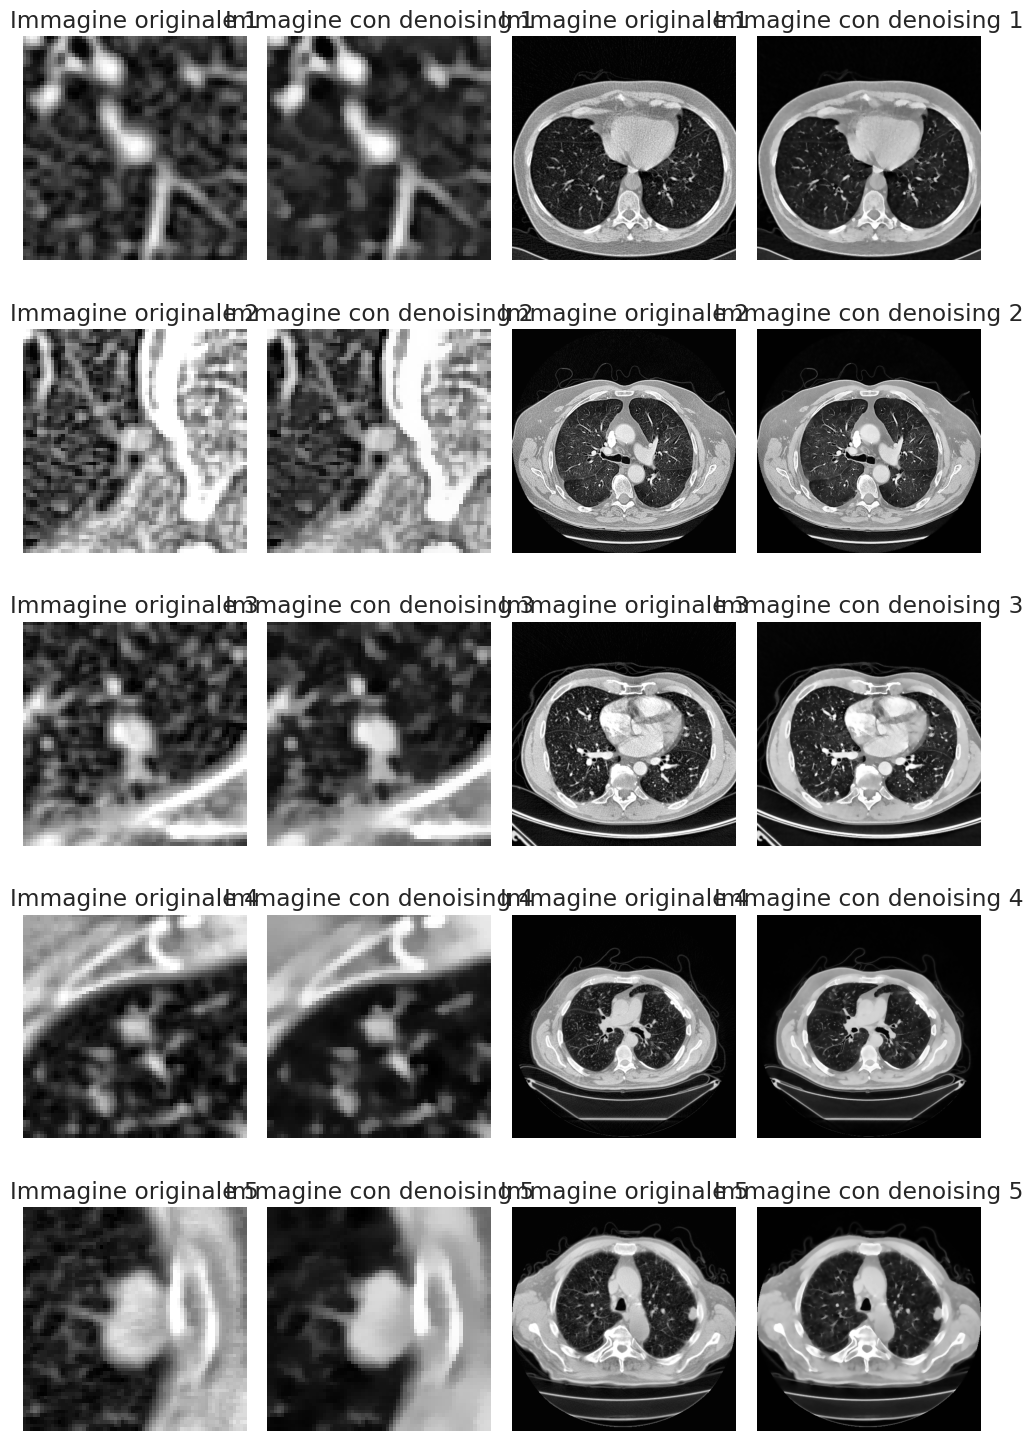

In [95]:

def denoise_image(image):
    # Filtro bilaterale per denoising
    return cv2.bilateralFilter(image, d=9, sigmaColor=20, sigmaSpace=20)


X_train_nodule_den = np.array([denoise_image(img) for img in X_train_nodule])
X_val_nodule_den = np.array([denoise_image(img) for img in X_val_nodule])
batch_size = 100  # Denosizza 100 immagini alla volta
X_train_full_den = []
X_val_full_den = []
for i in range(0, len(X_train_full), batch_size):
    batch = X_train_full[i:i+batch_size]
    denoised_batch = [denoise_image(img) for img in batch]
    X_train_full_den.extend(denoised_batch)
X_train_full_den = np.array(X_train_full_den)

for i in range(0, len(X_val_full), batch_size):
    batch = X_val_full[i:i+batch_size]
    denoised_batch = [denoise_image(img) for img in batch]
    X_val_full_den.extend(denoised_batch)
X_val_full_den = np.array(X_val_full_den)
print("Preprocessing completato con denoising su X_train_nodule!")

# Seleziona 5 immagini casuali dal dataset
n_images = 5
random_indices = np.random.choice(len(X_train_nodule), n_images, replace=False)
sample_images = [X_train_nodule[i] for i in random_indices]
sample_images_den = [X_train_nodule_den[i] for i in random_indices]
sample_images_full = [X_train_full[i] for i in random_indices]
sample_images_full_den = [X_train_full_den[i] for i in random_indices]

# Visualizza le immagini prima e dopo CLAHE
fig, axes = plt.subplots(n_images, 4, figsize=(10, 15))

for i in range(n_images):
    # Immagine originale
    axes[i, 0].imshow(sample_images[i], cmap='gray')
    axes[i, 0].set_title(f"Immagine originale {i+1}")
    axes[i, 0].axis('off')
    
    # Immagine con CLAHE
    axes[i, 1].imshow(sample_images_den[i], cmap='gray')
    axes[i, 1].set_title(f"Immagine con denoising {i+1}")
    axes[i, 1].axis('off')

    # Immagine originale full
    axes[i, 2].imshow(sample_images_full[i], cmap='gray')
    axes[i, 2].set_title(f"Immagine originale {i+1}")
    axes[i, 2].axis('off')
    
    # Immagine con CLAHE
    axes[i, 3].imshow(sample_images_full_den[i], cmap='gray')
    axes[i, 3].set_title(f"Immagine con denoising {i+1}")
    axes[i, 3].axis('off')
    
    

plt.tight_layout()
plt.show()

X_train_nodule=X_train_nodule_den
X_val_nodule=X_val_nodule_den
X_train_full=X_train_full_den
X_val_full=X_val_full_den


In [96]:
# Calcola i valori minimi e massimi per i tuoi dati
min_full = np.min(X_train_full)
max_full = np.max(X_train_full)
min_nodule = np.min(X_train_nodule)
max_nodule = np.max(X_train_nodule)
min_nodule_val=np.min(X_val_nodule)
max_nodule_val=np.max(X_val_nodule)

print(f"max di full: {max_full}")
print(f"min di full: {min_full}")
print(f"max di nodule: {max_nodule}")
print(f"min di nodule: {min_nodule}")

max di full: 255
min di full: 1
max di nodule: 255
min di nodule: 8


In [97]:
from tensorflow.keras.applications import mobilenet_v2

'''#X_train_full = np.repeat(X_train_full, 3, axis=-1)  # Replica il canale per RGB
#X_val_full = np.repeat(X_val_full, 3, axis=-1)  # Replica il canale per RGB
#X_train_nodule = np.repeat(X_train_nodule, 3, axis=-1)  # Replica il canale per RGB
#X_val_nodule = np.repeat(X_val_nodule, 3, axis=-1)  # Replica il canale per RGB
'''
X_train_full = ((X_train_full - min_full) / (max_full - min_full)) #*255
X_val_full = ((X_val_full - min_full) / (max_full - min_full)) #*255
X_train_nodule = ((X_train_nodule - min_nodule) / (max_nodule - min_nodule)) #*255
X_val_nodule = ((X_val_nodule - min_nodule) / (max_nodule - min_nodule)) #*255

#X_train_full=keras.applications.resnet.preprocess_input(X_train_full)
#X_val_full=keras.applications.resnet.preprocess_input(X_val_full)
#X_train_full=keras.applications.densenet.preprocess_input(X_train_full)
#X_val_full=keras.applications.densenet.preprocess_input(X_val_full)
#X_train_full =keras.applications.mobilenet_v2.preprocess_input(X_train_full)
#X_val_full = keras.applications.mobilenet_v2.preprocess_input(X_val_full)
#X_train_nodule = keras.applications.mobilenet_v2.preprocess_input(X_train_nodule)
#X_val_nodule = keras.applications.mobilenet_v2.preprocess_input(X_val_nodule)

# Calcola i valori minimi e massimi per i tuoi dati
min_full = np.min(X_train_full)
max_full = np.max(X_train_full)
print(f"max di full: {max_full}")
print(f"min di full: {min_full}")

max di full: 1.0
min di full: 0.0


In [98]:

# Calcolo della media di tutte le immagini nel dataset
full_mean_pixel = np.mean(X_train_full)
X_train_full = X_train_full - full_mean_pixel
X_val_full = X_val_full - full_mean_pixel

nodule_mean_pixel = np.mean(X_train_nodule)
X_train_nodule = X_train_nodule - nodule_mean_pixel
X_val_nodule = X_val_nodule - nodule_mean_pixel

# Calcola i valori minimi e massimi per i tuoi dati
min_full = np.min(X_train_full)
max_full = np.max(X_train_full)
min_nodule = np.min(X_train_nodule)
max_nodule = np.max(X_train_nodule)

print(f"max di full: {max_full}")
print(f"min di full: {min_full}")
print(f"max di nodule: {max_nodule}")
print(f"min di nodule: {min_nodule}")


max di full: 0.6792730543330188
min di full: -0.3207269456669812
max di nodule: 0.6363572775217097
min di nodule: -0.36364272247829027


class distribution

number of samples for each class: 
{0: 1381, 1: 439}


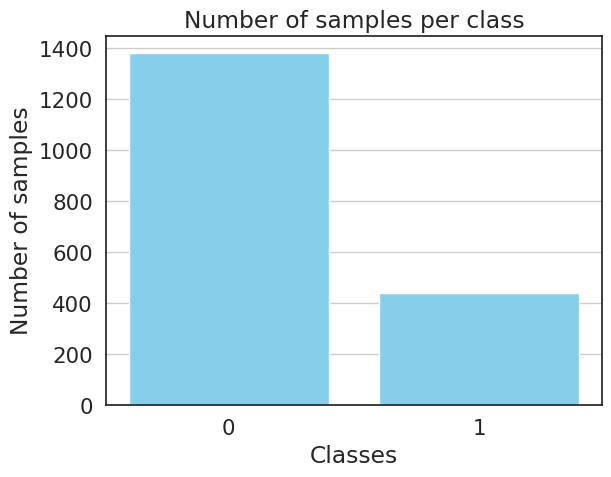

class weights full: {0: 0.6589427950760318, 1: 2.072892938496583}


In [99]:
# Binary distribution and class weights
unique, counts = np.unique(y_train_full_bin, return_counts=True)
print("number of samples for each class: ")
print(dict(zip(unique, counts)))

# show
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

# CLASS WEIGHTS
weights_full_bin = compute_class_weight('balanced', classes=np.unique(y_train_full_bin), y=y_train_full_bin)
weights_full_bin = dict(enumerate(weights_full_bin))
print("class weights full:", weights_full_bin)

number of samples for each class: 
{1.0: 188, 2.0: 355, 3.0: 838, 4.0: 321, 5.0: 118}


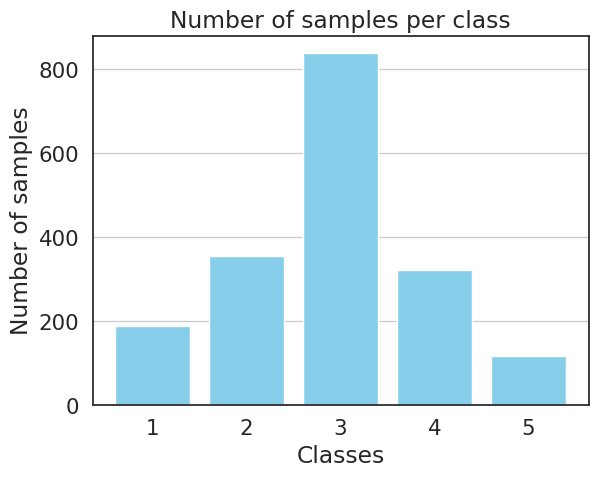

class weights full: {0: 1.9361702127659575, 1: 1.0253521126760563, 2: 0.4343675417661098, 3: 1.1339563862928348, 4: 3.0847457627118646}


In [100]:
# 1. FULL_SLICED

unique, counts = np.unique(y_train_full, return_counts=True)
print("number of samples for each class: ")
print(dict(zip(unique, counts)))

# show
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

# CLASS WEIGHTS
class_weights_full = compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weights_full = dict(enumerate(class_weights_full))
print("class weights full:", class_weights_full)


number of samples for each class: 
{1.0: 188, 2.0: 355, 3.0: 838, 4.0: 321, 5.0: 118}


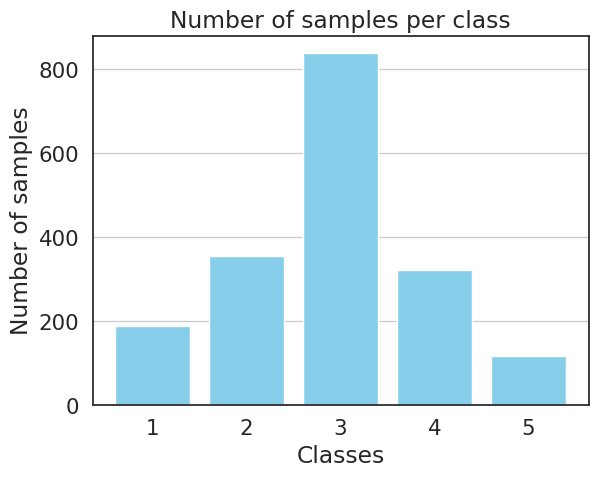

class weights nodule: {0: 1.9361702127659575, 1: 1.0253521126760563, 2: 0.4343675417661098, 3: 1.1339563862928348, 4: 3.0847457627118646}


In [101]:
# 2. NODULE

unique, counts = np.unique(y_train_nodule, return_counts=True)
print("number of samples for each class: ")
print(dict(zip(unique, counts)))

# show
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

# CLASS WEIGHTS
class_weights_nodule = compute_class_weight('balanced', classes=np.unique(y_train_nodule), y=y_train_nodule)
class_weights_nodule = dict(enumerate(class_weights_nodule))
print("class weights nodule:", class_weights_nodule)


# the 2 are very similar (as expected) but slighly different (because in the full_sliced we have removed some samples)

one-hot encoding

In [102]:
# Convert labels to categorical format using one-hot encoding
# in one-hot the index start from 0 => i have to convert into from 0 to 4 in order to have 5 classes
y_train_full = tfk.utils.to_categorical(y_train_full - 1)
y_val_full = tfk.utils.to_categorical(y_val_full - 1)
y_train_nodule = tfk.utils.to_categorical(y_train_nodule - 1)
y_val_nodule = tfk.utils.to_categorical(y_val_nodule - 1)



print(y_val_full.shape)
# ok, 5 classes (0-4 which corrispond to the real classes 1-5) => at the end I have to make +1 to the predictions

(456, 5)


## 🎨 Augmentation

## 🏗️ Model

### 1. full_slice 5-class

In [103]:
# Input shape for the model
input_shape = X_train_nodule.shape[1:]

# Output shape for the model
#output_shape = y_train_nodule.shape[1]
output_shape=5

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (64, 64)
Output Shape: 5


In [104]:
# set batch size for training
BATCH_SIZE = 16

# set learning rate for the optimiser
LEARNING_RATE = 1e-4

# set early stopping patience threshold
PATIENCE = 25

# set maximum number of training epochs
EPOCHS = 250


In [105]:
# Aggiungi un asse per il canale
X_train_full = np.expand_dims(X_train_full, axis=-1)  # Diventa 64x64x1
X_val_full = np.expand_dims(X_val_full, axis=-1)      # Diventa 64x64x1

X_train_full=tf.image.resize(X_train_full, (256, 256))
X_val_full=tf.image.resize(X_val_full, (256, 256))

# Ripeti lungo l'asse del canale per portare a 64x64x3
X_train_full = np.repeat(X_train_full, 3, axis=-1)    # Diventa 64x64x3
X_val_full = np.repeat(X_val_full, 3, axis=-1)        # Diventa 64x64x3

In [106]:
from tensorflow import keras
augmentation= keras.Sequential([
    # trasformazioni geometriche
    #keras_cv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3), # applica ≠ trasformazioni casualmente (scalamento, rotazioni, ...)
    #tfkl.RandomFlip("horizontal", seed=seed),  # Ribaltamenti completi
    #tfkl.RandomTranslation(0.1, 0.1, fill_mode='wrap', seed=seed),  # Maggiore traslazione
    #tfkl.RandomRotation(0.3, fill_mode='reflect', seed=seed),  # Rotazioni
    #tfkl.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode='nearest', seed=seed),
    #keras_cv.layers.RandomShear(x_factor=0.01, y_factor=0.01),   # distorsioni geometriche (immagini inclinate)

    # tecniche di mescolamento
    #keras_cv.layers.CutMix(), # sostituisce una porzione di immagine con una di un'altra immagine
    #keras_cv.layers.MixUp(),  # somma due imagini in maniera lineare
    #keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2), # non ha senso qui (magari mi oscura il tumore)
    tfkl.RandomBrightness(0.1, value_range=(0,1), seed=seed),  # Variazione luminosità ridotta
    keras_cv.layers.AutoContrast(value_range=(0, 1)),
    keras_cv.layers.RandomSharpness(factor=0.1, value_range=(0, 1)),
], name='augmentation')


In [107]:
import tensorflow as tf

# Preprocess function for training dataset
def preprocess_train(x):
    #x = augmentation(x)  # Apply augmentation (if you have a function defined for it)
    return x

# Preprocess function for validation dataset
def preprocess_val(x):
    # Ensure x is in float32 format (if needed)
    return tf.cast(x, tf.float32)

# Create the training and validation datasets and apply preprocessing
train_ds = tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full, train_coords))
train_ds = train_ds.map(lambda x, y, coords: (preprocess_train(x), {'output_layer_class': y, 'output_layer_regr': coords}), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_full, y_val_full, val_coords))
val_ds = val_ds.map(lambda x, y, coords: (preprocess_val(x), {'output_layer_class': y, 'output_layer_regr': coords}), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)




In [108]:
import tensorflow as tf

# Preprocess function for training dataset
def preprocess_train(x):
    #x = augmentation(x)  # Apply augmentation (if you have a function defined for it)
    return x

# Preprocess function for validation dataset
def preprocess_val(x):
    # Ensure x is in float32 format (if needed)
    return tf.cast(x, tf.float32)

# Create the training and validation datasets and apply preprocessing
train_ds_bin = tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full_bin, train_coords))
train_ds_bin = train_ds_bin.map(lambda x, y, coords: (preprocess_train(x), {'output_layer_class': y, 'output_layer_regr': coords}), num_parallel_calls=tf.data.AUTOTUNE)

val_ds_bin = tf.data.Dataset.from_tensor_slices((X_val_full, y_val_full_bin, val_coords))
val_ds_bin = val_ds_bin.map(lambda x, y, coords: (preprocess_val(x), {'output_layer_class': y, 'output_layer_regr': coords}), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds_bin = train_ds_bin.batch(32)
val_ds_bin = val_ds_bin.batch(32)
train_ds_bin = train_ds_bin.prefetch(tf.data.AUTOTUNE)
val_ds_bin = val_ds_bin.prefetch(tf.data.AUTOTUNE)




In [109]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

def build_model(
    input_shape=(256, 256, 3),
    num_classes=5,
    seed=42
):
    # Create the base model
    base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape)

    # Load pretrained weights
    base_model.load_weights('/kaggle/input/models/keras/default/1/RadImageNet-IRV2_notop.h5')

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze only the last 30 layers
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):  # Avoid fine-tuning BatchNorm layers
            layer.trainable = True

    # Define input tensor
    inputs = layers.Input(shape=input_shape)

    # Forward pass through the base model
    x = base_model(inputs, training=False)  

    # Add final layers

    x = layers.GlobalAveragePooling2D()(x)
    # Classification Head
    x_class = layers.Dense(256, activation='relu')(x)
    x_class = layers.Dropout(0.5)(x_class)
    output_classification = layers.Dense(5, activation='softmax', name='output_layer_class')(x_class)
    
    # Regression Head
    x_reg = layers.Dense(256, activation='relu')(x)
    x_reg = layers.Dropout(0.5)(x_reg)
    output_regression = layers.Dense(2, activation='linear', name='output_layer_regr')(x_reg)
    model = tfk.Model(inputs=inputs, outputs=[output_classification,output_regression], name='RadimageNet')

    return model


In [110]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
#tfk.utils.plot_model(model, expand_nested=True, show_trainable=True,  dpi=70)

Model: "RadimageNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_5          │ (None, 256, 256, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_resnet_v2    │ (None, 6, 6, 1536)   │   54,336,736 │ input_layer_5[0][0] │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ input_layer_4     │ (None, 256, 256, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_406        │ (None, 127, 127, 32) │          864 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 127, 127, 32) │           96 │ -                   │    N    │
│ batch_normalization_4… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_406    │ (None, 127, 127, 32) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_407        │ (None, 125, 125, 32) │        9,216 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 125, 125, 32) │           96 │ -                   │    N    │
│ batch_normalization_4… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_407    │ (None, 125, 125, 32) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_408        │ (None, 125, 125, 64) │       18,432 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 125, 125, 64) │          192 │ -                   │    N    │
│ batch_normalization_4… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_408    │ (None, 125, 125, 64) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├──────────────────────

 Total params: 55,125,479 (210.29 MB)

 Trainable params: 7,522,631 (28.70 MB)

 Non-trainable params: 47,602,848 (181.59 MB)

In [111]:
import tensorflow.keras.backend as K
@tf.keras.utils.register_keras_serializable()


def weighted_categorical_crossentropy(y_true, y_pred):
    """Applies class weights to the categorical crossentropy loss."""
    weights = tf.constant(list(class_weights_nodule.values()), dtype=tf.float32)  # Convert dict to tensor
    y_true_indices = tf.argmax(y_true, axis=-1)  # Convert one-hot to class indices
    sample_weights = tf.gather(weights, y_true_indices)  # Get corresponding weight for each sample
    
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss * sample_weights  # Scale loss by class weight


In [112]:

# Set learning rate
LEARNING_RATE = 1e-3

# Optimizer
optimizer = tf.keras.optimizers.AdamW(LEARNING_RATE)



# Define the loss functions for classification and regression
classification_loss = tf.keras.losses.CategoricalCrossentropy()
regression_loss = tf.keras.losses.MeanSquaredError()  

# Compile the model with separate losses for each output
model.compile(
    loss={
        'output_layer_class': weighted_categorical_crossentropy,
        'output_layer_regr': regression_loss
    },
    optimizer=optimizer,
    metrics={
        'output_layer_class': 'accuracy',  # Classification accuracy
        'output_layer_regr': 'mae'         # Mean Absolute Error for regression (optional)
    }
)


In [113]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class DynamicLossWeighting(Callback):
    def __init__(self, alpha=0.5, beta=0.5):
        super(DynamicLossWeighting, self).__init__()
        self.alpha = alpha  # Initial weight for classification
        self.beta = beta    # Initial weight for regression

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Get current validation losses
        class_loss = logs.get('val_output_layer_class_loss', 1.0)
        regr_loss = logs.get('val_output_layer_regr_loss', 1.0)

        # Normalize losses
        total_loss = class_loss + regr_loss
        self.alpha = class_loss / total_loss
        self.beta = regr_loss / total_loss

        print(f"Epoch {epoch + 1}: Updated Weights - Alpha: {self.alpha:.4f}, Beta: {self.beta:.4f}")

        # Update the loss weights dynamically
        self.model.loss_weights = {'output_layer_class': self.alpha, 'output_layer_regr': self.beta}



In [114]:
### Setup callbacks

# Initialize DynamicLossWeighting callback
dynamic_loss_callback = DynamicLossWeighting()
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_layer_class_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_delta=1e-5)


In [115]:
history = model.fit(
    train_ds,
    epochs=250,
    validation_data=val_ds,
    callbacks=[dynamic_loss_callback,early_stopping, LR_schedule],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_output_layer_class_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/250
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 1.7495 - output_layer_class_accuracy: 0.2029 - output_layer_class_loss: 1.6016 - output_layer_regr_loss: 0.1478 - output_layer_regr_mae: 0.2983Epoch 1: Updated Weights - Alpha: 0.9696, Beta: 0.0304
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 686ms/step - loss: 1.7487 - output_layer_class_accuracy: 0.2028 - output_layer_class_loss: 1.6017 - output_layer_regr_loss: 0.1469 - output_layer_regr_mae: 0.2974 - val_loss: 1.6106 - val_output_layer_class_accuracy: 0.2237 - val_output_layer_class_loss: 1.6237 - val_output_layer_regr_loss: 0.0509 - val_output_layer_regr_mae: 0.1883 - learning_rate: 0.0010
Epoch 2/250
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 1.5842 - output_layer_class_accuracy: 0.2174 - output_layer_class_loss: 1.5228 - output_layer_regr_loss: 0.0614 - output_layer_regr_mae: 0.2036Epoch 2: Updated Weights - Alpha: 0.9673, Beta: 0.0327
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - loss: 1.5841 - output_layer_class_accuracy: 0.21

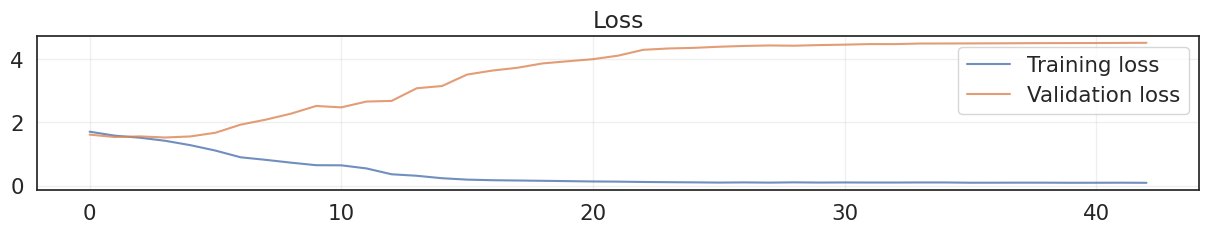

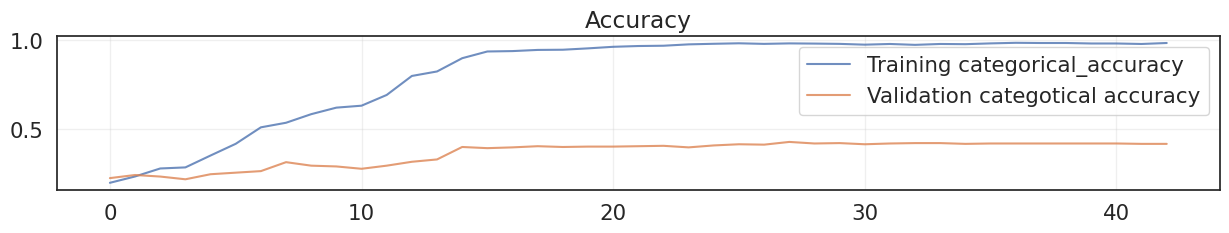

Classification Predictions Shape: (456,)
Regression Predictions Shape: (456, 2)
First Classification Prediction: 4
First Regression Prediction: [0.42699146 0.575906  ]
Ground Truth Classification: [0. 1. 0. 0. 0.]
Accuracy score over the test set: 0.4276
Precision score over the test set: 0.403
Recall score over the test set: 0.4276
F1 score over the test set: 0.4017


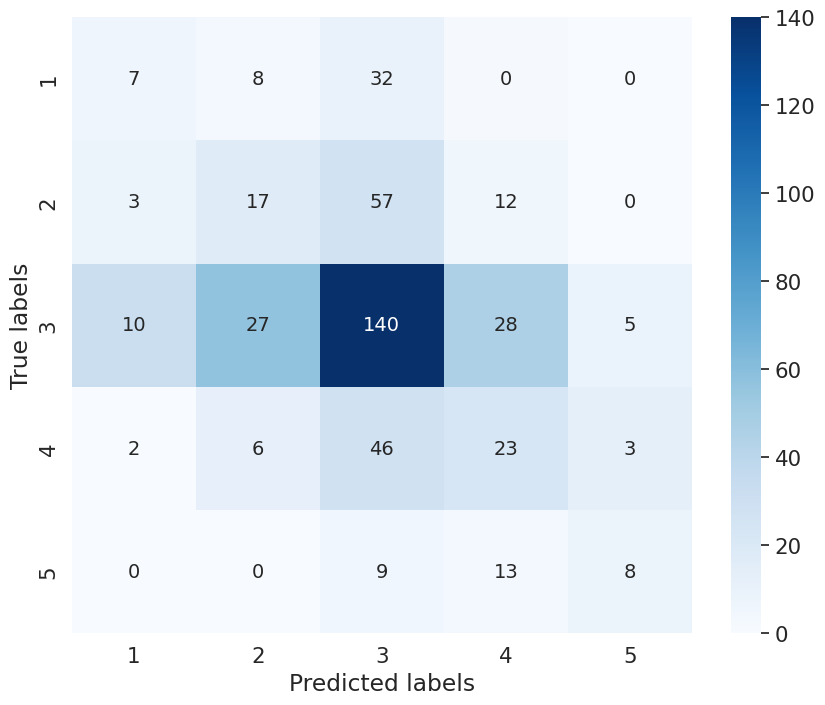

In [116]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['output_layer_class_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_output_layer_class_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
import numpy as np

# Make predictions
pred_classes_nodule, pred_regression_nodule = model.predict(X_val_full, verbose=0)

# Convert classification output from one-hot encoding to class labels
pred_classes_nodule = np.argmax(pred_classes_nodule, axis=1) + 1

# Print outputs
print("Classification Predictions Shape:", pred_classes_nodule.shape)
print("Regression Predictions Shape:", pred_regression_nodule.shape)

print("First Classification Prediction:", pred_classes_nodule[0])
print("First Regression Prediction:", pred_regression_nodule[0])

print("Ground Truth Classification:", y_val_nodule[0])

# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

BINARY

In [117]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

def build_model(
    input_shape=(256, 256, 3),
    num_classes=5,
    seed=42
):
    # Create the base model
    base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape)

    # Load pretrained weights
    base_model.load_weights('/kaggle/input/models/keras/default/1/RadImageNet-IRV2_notop.h5')

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze only the last 30 layers
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):  # Avoid fine-tuning BatchNorm layers
            layer.trainable = True

    # Define input tensor
    inputs = layers.Input(shape=input_shape)

    # Forward pass through the base model
    x = base_model(inputs, training=False)  

    # Add final layers

    x = layers.GlobalAveragePooling2D()(x)
    # Classification Head
    x_class = layers.Dense(256, activation='relu')(x)
    x_class = layers.Dropout(0.5)(x_class)
    output_classification = layers.Dense(1, activation='sigmoid', name='output_layer_class')(x_class)
    
    # Regression Head
    x_reg = layers.Dense(256, activation='relu')(x)
    x_reg = layers.Dropout(0.5)(x_reg)
    output_regression = layers.Dense(2, activation='linear', name='output_layer_regr')(x_reg)
    model = tfk.Model(inputs=inputs, outputs=[output_classification,output_regression], name='RadimageNet')

    return model

In [118]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
#tfk.utils.plot_model(model, expand_nested=True, show_trainable=True,  dpi=70)

Model: "RadimageNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_7          │ (None, 256, 256, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ inception_resnet_v2    │ (None, 6, 6, 1536)   │   54,336,736 │ input_layer_7[0][0] │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ input_layer_6     │ (None, 256, 256, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_609        │ (None, 127, 127, 32) │          864 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 127, 127, 32) │           96 │ -                   │    N    │
│ batch_normalization_6… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_609    │ (None, 127, 127, 32) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_610        │ (None, 125, 125, 32) │        9,216 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 125, 125, 32) │           96 │ -                   │    N    │
│ batch_normalization_6… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_610    │ (None, 125, 125, 32) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv2d_611        │ (None, 125, 125, 64) │       18,432 │ -                   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 125, 125, 64) │          192 │ -                   │    N    │
│ batch_normalization_6… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation_611    │ (None, 125, 125, 64) │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├──────────────────────

 Total params: 55,124,451 (210.28 MB)

 Trainable params: 7,521,603 (28.69 MB)

 Non-trainable params: 47,602,848 (181.59 MB)

In [119]:
import tensorflow.keras.backend as K
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred, class_weights):
    """
    Custom loss function that applies class weights to binary crossentropy.

    Args:
        y_true: True labels (0 or 1).
        y_pred: Predicted probabilities (sigmoid output).
        class_weights: Dictionary {0: weight_for_class_0, 1: weight_for_class_1}.

    Returns:
        Weighted binary crossentropy loss.
    """
    weights = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float32)

    # Get weights for each sample (0 -> weight[0], 1 -> weight[1])
    sample_weights = y_true * weights[1] + (1 - y_true) * weights[0]

    # Compute standard binary crossentropy
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Apply the sample-wise weights
    weighted_loss = loss * sample_weights

    return tf.reduce_mean(weighted_loss)  # Compute mean loss


In [120]:
LEARNING_RATE = 1e-4

# Optimizer
optimizer = tf.keras.optimizers.AdamW(LEARNING_RATE)



# Define the loss functions for classification and regression
classification_loss = lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weights_full_bin)
regression_loss = tf.keras.losses.MeanSquaredError()  

# Compile the model with separate losses for each output
model.compile(
    loss={
        'output_layer_class': classification_loss,
        'output_layer_regr': regression_loss
    },
    optimizer=optimizer,
    metrics={
        'output_layer_class': 'binary_accuracy',  # Binary accuracy for classification
        'output_layer_regr': 'mae'  # Mean Absolute Error for regression
    }
)


In [121]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class DynamicLossWeighting(Callback):
    def __init__(self, alpha=0.5, beta=0.5):
        super(DynamicLossWeighting, self).__init__()
        self.alpha = alpha  # Initial weight for classification
        self.beta = beta    # Initial weight for regression

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Get current validation losses
        class_loss = logs.get('val_output_layer_class_loss', 1.0)
        regr_loss = logs.get('val_output_layer_regr_loss', 1.0)

        # Normalize losses
        total_loss = class_loss + regr_loss
        self.alpha = class_loss / total_loss
        self.beta = regr_loss / total_loss

        print(f"Epoch {epoch + 1}: Updated Weights - Alpha: {self.alpha:.4f}, Beta: {self.beta:.4f}")

        # Update the loss weights dynamically
        self.model.loss_weights = {'output_layer_class': self.alpha, 'output_layer_regr': self.beta}



In [122]:
### Setup callbacks

# Initialize DynamicLossWeighting callback
dynamic_loss_callback = DynamicLossWeighting()
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_layer_class_binary_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_delta=1e-5)

In [123]:
history = model.fit(
    train_ds_bin,
    epochs=250,
    validation_data=val_ds_bin,
    callbacks=[dynamic_loss_callback,early_stopping, LR_schedule],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_output_layer_class_binary_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/250
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.7758 - output_layer_class_binary_accuracy: 0.7023 - output_layer_class_loss: 0.5970 - output_layer_regr_loss: 0.1788 - output_layer_regr_mae: 0.3305Epoch 1: Updated Weights - Alpha: 0.9113, Beta: 0.0887
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 663ms/step - loss: 0.7743 - output_layer_class_binary_accuracy: 0.7029 - output_layer_class_loss: 0.5968 - output_layer_regr_loss: 0.1775 - output_layer_regr_mae: 0.3293 - val_loss: 0.6080 - val_output_layer_class_binary_accuracy: 0.7588 - val_output_layer_class_loss: 0.5656 - val_output_layer_regr_loss: 0.0550 - val_output_layer_regr_mae: 0.1956 - learning_rate: 1.0000e-04
Epoch 2/250
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.5955 - output_layer_class_binary_accuracy: 0.7725 - output_layer_class_loss: 0.5304 - output_layer_regr_loss: 0.0650 - output_layer_regr_mae: 0.2091Epoch 2: Updated Weights - Alpha: 0.9150, Beta: 0.0850
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - loss: 0.5958 - o

Classification Predictions Shape: (456, 1)
Regression Predictions Shape: (456, 2)
First Classification Prediction: [0]
First Regression Prediction: [0.490468 0.490842]
Ground Truth Classification: 0
Accuracy score over the test set: 0.7807
Precision score over the test set: 0.6923
Recall score over the test set: 0.1636
F1 score over the test set: 0.2647


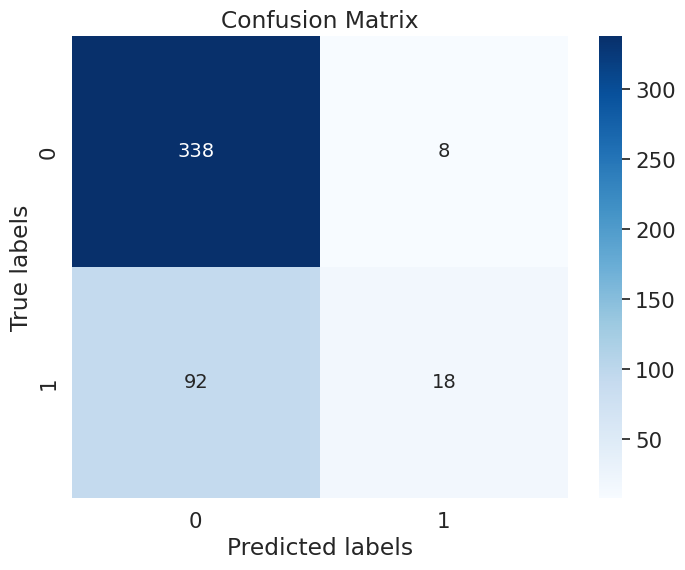

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plot training and validation loss
# plt.figure(figsize=(15, 2))
# plt.plot(history['loss'], label='Training loss', alpha=.8)
# plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
# plt.title('Loss')
# plt.legend()
# plt.grid(alpha=.3)

# # Plot training and validation accuracy
# plt.figure(figsize=(15, 2))
# plt.plot(history['output_layer_class_accuracy'], label='Training accuracy', alpha=.8)
# plt.plot(history['val_output_layer_class_accuracy'], label='Validation accuracy', alpha=.8)
# plt.title('Accuracy')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

# Make predictions
pred_classes_nodule, pred_regression_nodule = model.predict(X_val_full, verbose=0)

# Convert the output to binary classification (0 or 1)
pred_classes_nodule = (pred_classes_nodule > 0.5).astype(int)  # Threshold at 0.5 for binary

# Print outputs
print("Classification Predictions Shape:", pred_classes_nodule.shape)
print("Regression Predictions Shape:", pred_regression_nodule.shape)

print("First Classification Prediction:", pred_classes_nodule[0])
print("First Regression Prediction:", pred_regression_nodule[0])

print("Ground Truth Classification:", y_val_full_bin[0])

# Calculate and display accuracy, precision, recall, F1 score for binary classification
accuracy = accuracy_score(y_val_full_bin, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(y_val_full_bin, pred_classes_nodule, average='binary')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(y_val_full_bin, pred_classes_nodule, average='binary')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(y_val_full_bin, pred_classes_nodule, average='binary')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix for binary classification
cm = confusion_matrix(y_val_full_bin, pred_classes_nodule)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()
